In [4]:
import pandas as pd

# Load the CSV file to examine its contents
file_path = '/Users/michael/Desktop/SpringData2024-main/data/regression/final_all_entries_filtered_counties_parishes.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure and the type of data it contains
data.head()

,geotype,geoid,geoname,varname,x2010,x2011,x2012,x2013,x2014,x2015,...,x2017,x2018,x2019,x2020,x2021,x2022,x2023,State,Cluster,area_type
0,county,22025,"Catahoula Parish, Louisiana",co2limits,NaN,NaN,NaN,NaN,56.0,NaN,...,NaN,57.49,53.98,54.48,52.31,NaN,NaN,LA,1.0,rural
1,county,22071,"Orleans Parish, Louisiana",co2limits,NaN,NaN,NaN,NaN,68.0,NaN,...,NaN,79.12,77.10,77.45,75.54,NaN,NaN,LA,1.0,urban
2,county,28049,"Hinds County, Mississippi",co2limits,NaN,NaN,NaN,NaN,58.0,NaN,...,NaN,72.37,68.94,69.36,69.18,NaN,NaN,MS,1.0,urban
3,county,28055,"Issaquena County, Mississippi",co2limits,NaN,NaN,NaN,NaN,55.0,NaN,...,NaN,63.40,60.60,60.13,59.33,NaN,NaN,MS,1.0,rural
4,county,41051,"Multnomah County, Oregon",co2limits,NaN,NaN,NaN,NaN,76.0,NaN,...,NaN,77.96,76.33,76.65,76.12,NaN,NaN,OR,2.0,urban


In [5]:
# Calculate the yearly average of the 'co2limits' variable across all counties/parishes
year_columns = [col for col in data.columns if col.startswith('x')]
yearly_averages = data[year_columns].mean()

# Convert the Series to a DataFrame for easier handling in subsequent analysis
aggregated_data = pd.DataFrame(yearly_averages, columns=['Average CO2 Limits']).reset_index()
aggregated_data.rename(columns={'index': 'Year'}, inplace=True)
aggregated_data['Year'] = aggregated_data['Year'].str.replace('x', '').astype(int)

aggregated_data

,Year,Average CO2 Limits
0,2010,NaN
1,2011,NaN
2,2012,NaN
3,2013,NaN
4,2014,64.333333
5,2015,NaN
6,2016,70.405833
7,2017,NaN
8,2018,59.202917
9,2019,59.877917


In [6]:
from pykalman import KalmanFilter
import numpy as np

# Prepare the data, replacing NaNs with a large negative number as a placeholder
# The Kalman Filter implementation will treat these as missing observations
data_with_nans = aggregated_data['Average CO2 Limits'].values

data_for_kalman = np.where(np.isnan(data_with_nans), np.nan, data_with_nans)
# Calculate the mean of the non-NaN values
mean_value = np.nanmean(data_with_nans)

# Replace NaN values with the mean
data_for_kalman = np.where(np.isnan(data_with_nans), mean_value, data_with_nans)

# Initialize the Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Estimate the parameters of the Kalman Filter
kf = kf.em(data_for_kalman, n_iter=5)

# Apply the Kalman Filter
(filtered_state_means, filtered_state_covariances) = kf.filter(data_for_kalman)

# Prepare the results for visualization
years = aggregated_data['Year']
estimated_co2_limits = filtered_state_means.flatten()

# Create a DataFrame for the estimated CO2 limits
estimated_data = pd.DataFrame({
    'Year': years,
    'Estimated CO2 Limits': estimated_co2_limits
})

estimated_data

,Year,Estimated CO2 Limits
0,2010,38.834158
1,2011,46.403703
2,2012,53.087926
3,2013,56.922622
4,2014,60.657464
5,2015,60.739990
6,2016,65.635144
7,2017,63.196295
8,2018,61.173312
9,2019,60.517076


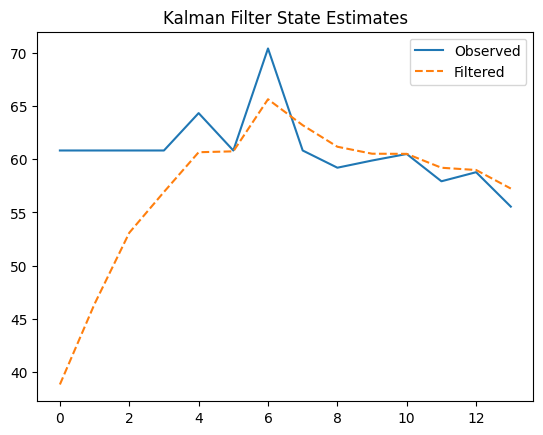

In [7]:
import matplotlib.pyplot as plt

# Plot the original data
plt.plot(data_for_kalman, label='Observed')

# Plot the filtered state estimates
plt.plot(filtered_state_means, label='Filtered', linestyle='--')

plt.legend()
plt.title('Kalman Filter State Estimates')
plt.show()